In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evaluation import (
    n_precision_at_recall_for_query,
    precision_at_recall_for_query,
    tnr_at_recall_for_query,
    find_last_relevant_for_query,
    average_precision_for_query,
    sqrt_n_precision_at_recall_for_query,
)

%matplotlib inline

In [64]:
runs = pickle.load(open("../data/0_external/runs.pkl", "rb"))

In [67]:
# remove "pubmedbert"
runs = {k: v for k, v in runs.items() if not k.startswith("pubmedbert")}

In [72]:
print(f"runs: {len(runs)}")
print(f"topics: {len(runs['bm25_abstract'])}")

runs: 20
topics: 100


In [5]:
qrels = pickle.load(open("../data/0_external/qrels.pkl", "rb"))

In [6]:
df = pd.DataFrame()
for run_name, run in runs.items():
    scores_dict = {}
    print(run_name)
    for query_id, rankings in run.items():
        if len(rankings) != len(qrels[query_id]):
            # add missing documents at the end of the ranking with score -1000
            for doc_id in qrels[query_id].keys():
                if doc_id not in rankings:
                    rankings[doc_id] = -1000

            # remove documents that are not in qrels
            rankings = {k: v for k, v in rankings.items() if k in qrels[query_id]}

        scores_dict[query_id] = {}
        # breakpoint()
        scores_dict[query_id]["model"] = run_name
        qrels_for_query = qrels[query_id]
        scores_dict[query_id]["nP@95%"] = n_precision_at_recall_for_query(
            rankings=rankings, qrels=qrels_for_query, recall_level=0.95
        )
        scores_dict[query_id]["P@95%"] = precision_at_recall_for_query(
            rankings=rankings, qrels=qrels_for_query, recall_level=0.95
        )
        scores_dict[query_id]["TNR@95%"] = tnr_at_recall_for_query(
            rankings=rankings, qrels=qrels_for_query, recall_level=0.95
        )
        scores_dict[query_id]["last_rel"] = find_last_relevant_for_query(
            rankings=rankings, qrels=qrels_for_query
        )
        scores_dict[query_id]["MAP"] = average_precision_for_query(
            rankings=rankings, qrels=qrels_for_query
        )
        scores_dict[query_id]["snP@95%"] = sqrt_n_precision_at_recall_for_query(
            rankings=rankings, qrels=qrels_for_query, recall_level=0.95
        )

        scores_dict[query_id]["Dataset size"] = len(rankings)
        scores_dict[query_id]["%Irrelevant"] = list(qrels_for_query.values()).count(
            0
        ) / len(qrels_for_query)
        scores_dict[query_id]["%Relevant"] = list(qrels_for_query.values()).count(
            1
        ) / len(qrels_for_query)
    print(len(df))
    df = pd.concat([df, pd.DataFrame(scores_dict).T])

bm25_abstract
0
bm25_title
100
bm25_query
200
bm25_criteria
300
tf-idf_abstract
400
tf-idf_title
500
tf-idf_query
600
tf-idf_criteria
700
MiniLM-256_abstract
800
MiniLM-256_title
900
MiniLM-256_query
1000
MiniLM-256_criteria
1100
mpnet_abstract
1200
mpnet_title
1300
mpnet_query
1400
mpnet_criteria
1500
S-BioBert_abstract
1600
S-BioBert_title
1700
S-BioBert_query
1800
S-BioBert_criteria
1900


In [8]:
# df.reset_index(names=['review_id']).groupby('review_id')[['Dataset size','qrels_len']].value_counts()

In [9]:
df[df["nP@95%"].isna()]

,model,nP@95%,P@95%,TNR@95%,last_rel,MAP,snP@95%,Dataset size,%Irrelevant,%Relevant


In [10]:
# drop NA for ["nP@95%"]
df = df.dropna(subset="nP@95%")
len(df)

2000

In [50]:
average_tnr = df.groupby("model")["TNR@95%"].mean().mean()
average_np = df.groupby("model")["nP@95%"].mean().mean()
average_p = df.groupby("model")["P@95%"].mean().mean()
average_last_rel = df.groupby("model")["last_rel"].mean().mean()
average_map = df.groupby("model")["MAP"].mean().mean()
average_snp = df.groupby("model")["snP@95%"].mean().mean()

# Correlation Analysis between nP@95% and other metrics

In [12]:
print(
    df[
        [
            "nP@95%",
            "P@95%",
            "TNR@95%",
            "last_rel",
            "MAP",
            "snP@95%",
            "Dataset size",
            "%Irrelevant",
            "%Relevant",
        ]
    ]
    .corr("spearman")
    .round(3)
    .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
\toprule
 & nP@95% & P@95% & TNR@95% & last_rel & MAP & snP@95% & Dataset size & %Irrelevant & %Relevant \\
\midrule
nP@95% & 1.000000 & 0.602000 & 0.655000 & -0.533000 & 0.570000 & 1.000000 & -0.299000 & -0.132000 & 0.132000 \\
P@95% & 0.602000 & 1.000000 & -0.027000 & 0.140000 & 0.910000 & 0.602000 & -0.724000 & -0.736000 & 0.736000 \\
TNR@95% & 0.655000 & -0.027000 & 1.000000 & -0.923000 & 0.014000 & 0.655000 & 0.273000 & 0.570000 & -0.570000 \\
last_rel & -0.533000 & 0.140000 & -0.923000 & 1.000000 & 0.097000 & -0.533000 & -0.249000 & -0.652000 & 0.652000 \\
MAP & 0.570000 & 0.910000 & 0.014000 & 0.097000 & 1.000000 & 0.570000 & -0.637000 & -0.639000 & 0.639000 \\
snP@95% & 1.000000 & 0.602000 & 0.655000 & -0.533000 & 0.570000 & 1.000000 & -0.299000 & -0.132000 & 0.132000 \\
Dataset size & -0.299000 & -0.724000 & 0.273000 & -0.249000 & -0.637000 & -0.299000 & 1.000000 & 0.769000 & -0.769000 \\
%Irrelevant & -0.132000 & -0.736000 & 0.570000 & -0.652000 & 

# Plot of nP@95% vs TNR@95%

In [13]:
sns.set_theme(style="whitegrid")

In [60]:
df["%Relevant"]

CD009784       0.025
CD002764    0.158371
CD010264    0.391304
CD009782    0.238095
CD003504    0.653846
              ...   
CD004241    0.029833
CD005055    0.012346
CD008392    0.002704
CD006839    0.033473
CD004479    0.053571
Name: %Relevant, Length: 2000, dtype: object

In [52]:
def plot_two_metrics(
    data: pd.DataFrame,
    metric1_column,
    metric2_column,
    metric1_name=None,
    metric2_name=None,
    average_metric1=None,
    average_metric2=None,
) -> plt.plot:
    sns.set_theme(style="whitegrid")

    marker_size_column = "%Relevant"

    plt.figure(figsize=(8, 3.5))  # You can adjust the dimensions as needed

    min_marker_size = 35  # Minimum marker size
    max_marker_size = 140  # Maximum marker size
    data_size_normalised = (
        data[marker_size_column] - data[marker_size_column].min()
    ) / (data[marker_size_column].max() - data[marker_size_column].min())
    marker_sizes = (
        min_marker_size + (max_marker_size - min_marker_size) * data_size_normalised
    )

    marker_sizes = marker_sizes.astype(float)

    # Create the scatterplot
    ax = sns.scatterplot(
        data=data,
        x=metric1_column,
        y=metric2_column,
        hue="model",
        palette="colorblind",  # Using a colorblind-friendly palette
        style="model",  # Different marker styles for each model
        size=marker_sizes.tolist(),  # Adjust the size of the markers
        alpha=0.7,  # Set transparency to avoid overplotting
    )

    # Add enhancements
    if metric1_name:
        plt.xlabel(metric1_name, fontsize=12)
    if metric2_name:
        plt.ylabel(metric2_name, fontsize=12)
    ax.legend(title="Model", loc="lower right")  # Move the legend outside the plot

    # Add reference lines if necessary set width of lines to 0.5
    if average_metric1:
        ax.axvline(
            x=average_np,
            color="gray",
            linestyle="--",
            label="Avg. nP",
            alpha=0.7,
            linewidth=1,
        )
    if average_metric2:
        ax.axhline(
            y=average_metric2,
            color="gray",
            linestyle="--",
            label="Avg. TNR",
            alpha=0.7,
            linewidth=1,
        )

    handles, labels = plt.gca().get_legend_handles_labels()
    # Filter out the handles and labels you don't want to show in the legend
    # This depends on how you have added your average lines and bubble sizes.
    # For example, if they are the last two handles, you can do:
    new_handles = handles[:-8]
    new_labels = labels[:-8]

    # Now create a new legend with the filtered handles and labels
    plt.legend(new_handles, new_labels, prop={"size": 6})

    # Save the figure
    plt.tight_layout()
    return plt

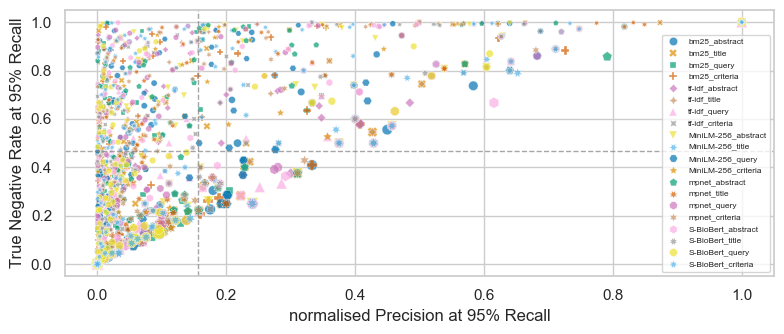

In [53]:
plt = plot_two_metrics(
    data=df,
    metric1_column="nP@95%",
    metric2_column="TNR@95%",
    metric1_name="normalised Precision at 95% Recall",
    metric2_name="True Negative Rate at 95% Recall",
    average_metric1=average_np,
    average_metric2=average_tnr,
)
plt.savefig("../reports/nP_at_95_vs_TNR_at_95.pdf", dpi=300)

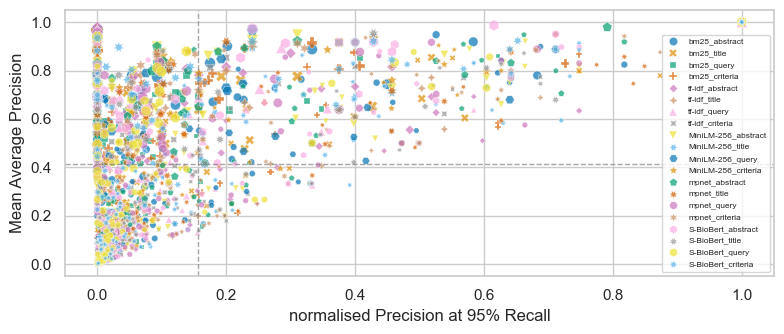

In [54]:
plt = plot_two_metrics(
    data=df,
    metric1_column="nP@95%",
    metric2_column="MAP",
    metric1_name="normalised Precision at 95% Recall",
    metric2_name="Mean Average Precision",
    average_metric1=average_p,
    average_metric2=average_map,
)
plt.savefig("../reports/nP_at_95_vs_MAP.pdf", dpi=300)

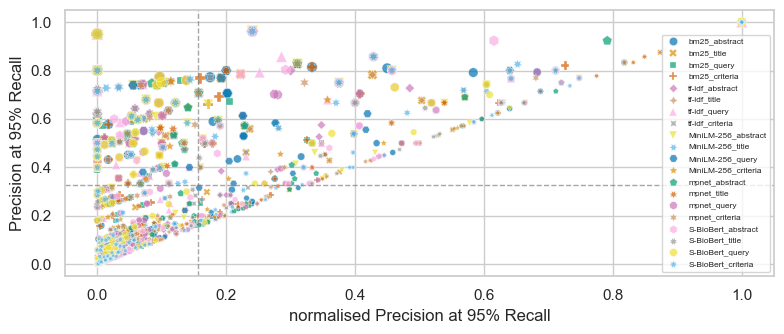

In [55]:
plt = plot_two_metrics(
    data=df,
    metric1_column="nP@95%",
    metric2_column="P@95%",
    metric1_name="normalised Precision at 95% Recall",
    metric2_name="Precision at 95% Recall",
    average_metric1=average_np,
    average_metric2=average_p,
)
plt.savefig("../reports/nP_at_95_vs_P_at_95.pdf", dpi=300)

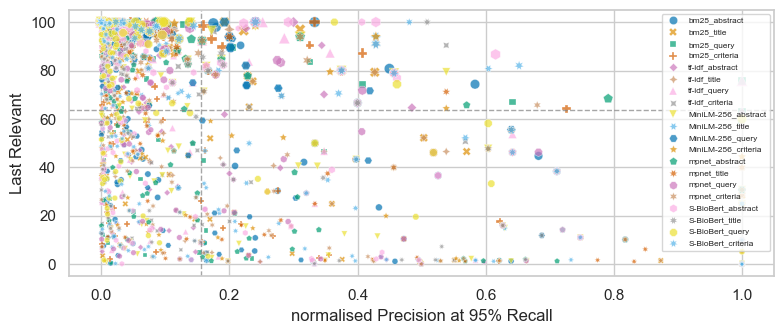

In [56]:
plt = plot_two_metrics(
    data=df,
    metric1_column="nP@95%",
    metric2_column="last_rel",
    metric1_name="normalised Precision at 95% Recall",
    metric2_name="Last Relevant",
    average_metric1=average_p,
    average_metric2=average_last_rel,
)

plt.savefig("../reports/nP_at_95_vs_LastRel.pdf", dpi=300)

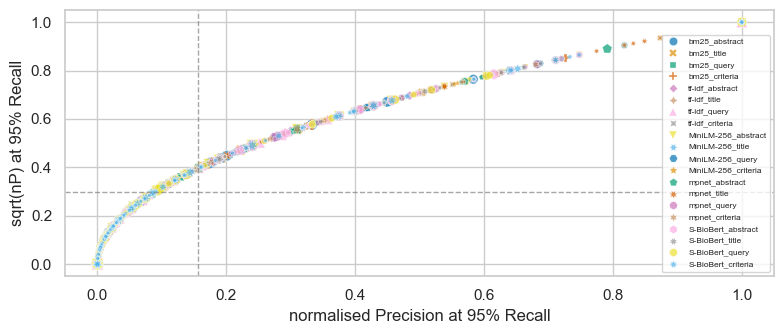

In [57]:
plt = plot_two_metrics(
    data=df,
    metric1_column="nP@95%",
    metric2_column="snP@95%",
    metric1_name="normalised Precision at 95% Recall",
    metric2_name="sqrt(nP) at 95% Recall",
    average_metric1=average_p,
    average_metric2=average_snp,
)
plt.savefig("../reports/nP_at_95_vs_sqrt_nP_at_95.pdf", dpi=300)

# Bland-Altman plot

In [19]:
# plot Bland-Altman Plot: This plot can be used to assess the agreement between nP@95% and TNR@95% for each model. It will help to visualize the extent of disagreement (bias) and the pattern of this disagreement across the range of measurements.


def bland_altman_plot(data1, data2, labels, data_sizes, *args, **kwargs):
    """
    Bland-Altman Plot.

    A Bland-Altman plot is a graphical method to analyze the differences
    between two methods of measurement. The mean of the measures is plotted
    against their difference.

    Parameters:
    - data1, data2: Arrays of the two sets of measurements to be compared.
    - labels : list Labels of the two sets of measurements. E.g. model name
    """
    min_marker_size = 35  # Minimum marker size
    max_marker_size = 140  # Maximum marker size
    data_size_normalised = (data_sizes - data_sizes.min()) / (
        data_sizes.max() - data_sizes.min()
    )
    marker_sizes = (
        min_marker_size + (max_marker_size - min_marker_size) * data_size_normalised
    )

    data1 = np.asarray(data1)
    data2 = np.asarray(data2)

    # Calculate means and differences
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    # Create plot
    plt.figure(figsize=(8, 5))

    # color items by labels. labels is a list of strings with the same length as data1 and data2
    sns.scatterplot(
        x=mean,
        y=diff,
        *args,
        **kwargs,
        hue=labels,
        style=labels,
        palette="colorblind",
        size=marker_sizes,
        alpha=0.7
    )

    plt.axhline(md, color="cadetblue", linestyle="--", alpha=0.7, linewidth=1.5)
    plt.axhline(md + 1.96 * sd, color="salmon", linestyle="--", alpha=0.7, linewidth=1)
    plt.axhline(md - 1.96 * sd, color="salmon", linestyle="--", alpha=0.7, linewidth=1)

    plt.text(
        mean.max(), md, "Mean", va="bottom", ha="right", color="cadetblue", alpha=0.7
    )
    plt.text(
        mean.max(),
        md + 1.96 * sd,
        "+1.96 SD",
        va="bottom",
        ha="right",
        color="salmon",
        alpha=0.7,
    )
    plt.text(
        mean.max(),
        md - 1.96 * sd,
        "-1.96 SD",
        va="bottom",
        ha="right",
        color="salmon",
        alpha=0.7,
    )

    # add legend
    # handles, _ = ax.get_legend_handles_labels()
    # ax.legend(handles, labels)

    plt.xlabel("Mean of Two Measures", fontsize=14)
    plt.ylabel("Difference Between Two Measures", fontsize=14)

    # turn off legend
    plt.legend([], [], frameon=False)

    plt.tight_layout()
    plt.savefig("../reports/np_tnr_bland_altman_plot.pdf", dpi=300)


# Example usage
# data1 = [your_data_set_1]
# data2 = [your_data_set_2]
# bland_altman_plot(data1, data2)

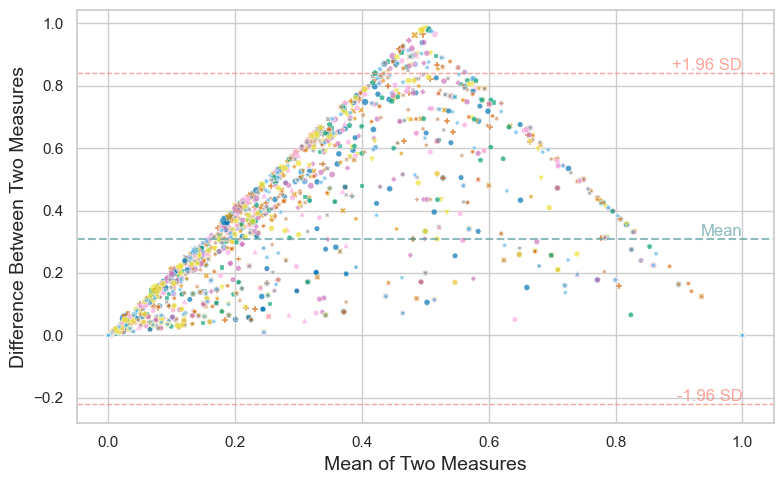

In [20]:
bland_altman_plot(
    df["TNR@95%"],
    df["nP@95%"],
    labels=df["model"].tolist(),
    data_sizes=df["Dataset size"],
)

# Average score by model and ranking

In [25]:
metrics = ["nP@95%", "P@95%", "TNR@95%", "last_rel", "MAP", "snP@95%"]
for metric in metrics:
    df[metric] = df[metric].astype(float)

In [26]:
import pandas as pd
from scipy import stats

In [27]:
df["last_rel"] = 100 - df["last_rel"]

In [28]:
df.groupby("model").mean()[metrics]

,nP@95%,P@95%,TNR@95%,last_rel,MAP,snP@95%
model,,,,,,
MiniLM-256_abstract,0.188969,0.361128,0.522238,59.274732,0.468661,0.346512
MiniLM-256_criteria,0.194083,0.355473,0.521020,60.066885,0.455862,0.341047
MiniLM-256_query,0.125360,0.300058,0.445975,65.042193,0.355457,0.269087
MiniLM-256_title,0.173572,0.346803,0.495749,62.274136,0.430589,0.326131
S-BioBert_abstract,0.162830,0.327334,0.491593,63.277593,0.448182,0.310317
S-BioBert_criteria,0.177001,0.342862,0.498789,62.068246,0.467955,0.315983
S-BioBert_query,0.096342,0.275034,0.365511,72.432387,0.334608,0.212207
S-BioBert_title,0.138294,0.319808,0.437146,65.959248,0.368937,0.271572
bm25_abstract,0.168285,0.341329,0.473703,63.191189,0.455580,0.309076


In [29]:
df.groupby("model").mean()[metrics].rank(ascending=False, method="min")

,nP@95%,P@95%,TNR@95%,last_rel,MAP,snP@95%
model,,,,,,
MiniLM-256_abstract,4.0,4.0,3.0,17.0,3.0,3.0
MiniLM-256_criteria,3.0,5.0,4.0,16.0,5.0,4.0
MiniLM-256_query,17.0,17.0,13.0,9.0,16.0,17.0
MiniLM-256_title,7.0,6.0,7.0,13.0,9.0,6.0
S-BioBert_abstract,9.0,10.0,8.0,10.0,7.0,8.0
S-BioBert_criteria,6.0,7.0,6.0,15.0,4.0,7.0
S-BioBert_query,20.0,19.0,20.0,1.0,19.0,20.0
S-BioBert_title,15.0,14.0,15.0,6.0,15.0,16.0
bm25_abstract,8.0,8.0,11.0,11.0,6.0,9.0


In [30]:
print(
    df.groupby("model")
    .mean()[metrics]
    .rank(ascending=False, method="min")
    .sort_values("nP@95%")
    .astype(int)
    .to_latex()
)

\begin{tabular}{lrrrrrr}
\toprule
 & nP@95% & P@95% & TNR@95% & last_rel & MAP & snP@95% \\
model &  &  &  &  &  &  \\
\midrule
mpnet_abstract & 1 & 1 & 1 & 20 & 1 & 1 \\
mpnet_criteria & 2 & 2 & 2 & 19 & 2 & 2 \\
MiniLM-256_criteria & 3 & 5 & 4 & 16 & 5 & 4 \\
MiniLM-256_abstract & 4 & 4 & 3 & 17 & 3 & 3 \\
mpnet_title & 5 & 3 & 5 & 18 & 8 & 5 \\
S-BioBert_criteria & 6 & 7 & 6 & 15 & 4 & 7 \\
MiniLM-256_title & 7 & 6 & 7 & 13 & 9 & 6 \\
bm25_abstract & 8 & 8 & 11 & 11 & 6 & 9 \\
S-BioBert_abstract & 9 & 10 & 8 & 10 & 7 & 8 \\
bm25_title & 10 & 9 & 12 & 8 & 11 & 11 \\
tf-idf_abstract & 11 & 11 & 9 & 12 & 12 & 10 \\
bm25_criteria & 12 & 13 & 17 & 4 & 10 & 15 \\
mpnet_query & 13 & 12 & 10 & 14 & 13 & 12 \\
tf-idf_title & 14 & 15 & 16 & 5 & 18 & 14 \\
S-BioBert_title & 15 & 14 & 15 & 6 & 15 & 16 \\
tf-idf_criteria & 16 & 16 & 14 & 7 & 14 & 13 \\
MiniLM-256_query & 17 & 17 & 13 & 9 & 16 & 17 \\
bm25_query & 18 & 18 & 18 & 3 & 17 & 18 \\
tf-idf_query & 19 & 20 & 19 & 2 & 20 & 19 \\
S-BioBer

In [31]:
df.fillna(0, inplace=True)

In [32]:
models = df["model"].unique()
# models = ['mpnet_criteria', 'mpnet_abstract', 'MiniLM-256_criteria', 'MiniLM-256_abstract', 'mpnet_title']
print(models)

n_comparisons = len(models) * (len(models) - 1) / 2
p_value = 0.05 / n_comparisons
print(f"p_value: {p_value}")


for m1_index, model1 in enumerate(models):
    if model1 != "mpnet_criteria":
        continue
    for m2_index, model2 in enumerate(models):
        # if m1_index >= m2_index:
        #     continue
        print(f"{model1} vs {model2}")
        print(
            stats.ttest_rel(
                df[df["model"] == model1]["nP@95%"], df[df["model"] == model2]["nP@95%"]
            )
        )
        print(
            stats.ttest_rel(
                df[df["model"] == model1]["P@95%"], df[df["model"] == model2]["P@95%"]
            )
        )
        print(
            stats.ttest_rel(
                df[df["model"] == model1]["TNR@95%"],
                df[df["model"] == model2]["TNR@95%"],
            )
        )
        print(
            stats.ttest_rel(
                df[df["model"] == model1]["last_rel"],
                df[df["model"] == model2]["last_rel"],
            )
        )
        print(
            stats.ttest_rel(
                df[df["model"] == model1]["MAP"], df[df["model"] == model2]["MAP"]
            )
        )
        print()

['bm25_abstract' 'bm25_title' 'bm25_query' 'bm25_criteria'
 'tf-idf_abstract' 'tf-idf_title' 'tf-idf_query' 'tf-idf_criteria'
 'MiniLM-256_abstract' 'MiniLM-256_title' 'MiniLM-256_query'
 'MiniLM-256_criteria' 'mpnet_abstract' 'mpnet_title' 'mpnet_query'
 'mpnet_criteria' 'S-BioBert_abstract' 'S-BioBert_title' 'S-BioBert_query'
 'S-BioBert_criteria']
p_value: 0.0002631578947368421
mpnet_criteria vs bm25_abstract
TtestResult(statistic=2.109349608808294, pvalue=0.03743688659169654, df=99)
TtestResult(statistic=2.192999255389206, pvalue=0.030648923028650552, df=99)
TtestResult(statistic=2.503742888233925, pvalue=0.013923673719904927, df=99)
TtestResult(statistic=-2.9190727536740826, pvalue=0.004346295663895301, df=99)
TtestResult(statistic=2.1061080357823134, pvalue=0.037724232337900905, df=99)

mpnet_criteria vs bm25_title
TtestResult(statistic=2.3050555857591375, pvalue=0.02325111239230115, df=99)
TtestResult(statistic=2.566133537002564, pvalue=0.01178224914582378, df=99)
TtestResult(st

In [33]:
models = df["model"].unique()
# models = ['mpnet_criteria', 'mpnet_abstract', 'MiniLM-256_criteria', 'MiniLM-256_abstract', 'mpnet_title']
print(models)

n_comparisons = len(models) * (len(models) - 1) / 2
p_value = 0.05 / n_comparisons
print(f"p_value: {p_value}")


for m1_index, model1 in enumerate(models):
    if model1 != "mpnet_criteria":
        continue
    for m2_index, model2 in enumerate(models):
        # if m1_index >= m2_index:
        #     continue
        print(f"{model1} vs {model2}")
        print(
            stats.ttest_ind(
                df[df["model"] == model1]["nP@95%"],
                df[df["model"] == model2]["nP@95%"],
                equal_var=False,
            )
        )
        print(
            stats.ttest_ind(
                df[df["model"] == model1]["P@95%"],
                df[df["model"] == model2]["P@95%"],
                equal_var=False,
            )
        )
        print(
            stats.ttest_ind(
                df[df["model"] == model1]["TNR@95%"],
                df[df["model"] == model2]["TNR@95%"],
                equal_var=False,
            )
        )
        print(
            stats.ttest_ind(
                df[df["model"] == model1]["last_rel"],
                df[df["model"] == model2]["last_rel"],
                equal_var=False,
            )
        )
        print(
            stats.ttest_ind(
                df[df["model"] == model1]["MAP"],
                df[df["model"] == model2]["MAP"],
                equal_var=False,
            )
        )
        print()

['bm25_abstract' 'bm25_title' 'bm25_query' 'bm25_criteria'
 'tf-idf_abstract' 'tf-idf_title' 'tf-idf_query' 'tf-idf_criteria'
 'MiniLM-256_abstract' 'MiniLM-256_title' 'MiniLM-256_query'
 'MiniLM-256_criteria' 'mpnet_abstract' 'mpnet_title' 'mpnet_query'
 'mpnet_criteria' 'S-BioBert_abstract' 'S-BioBert_title' 'S-BioBert_query'
 'S-BioBert_criteria']
p_value: 0.0002631578947368421
mpnet_criteria vs bm25_abstract
TtestResult(statistic=1.0528483230644659, pvalue=0.293703534322239, df=196.4876804690375)
TtestResult(statistic=0.75948813737468, pvalue=0.44846390678418124, df=197.99442674405407)
TtestResult(statistic=1.25278439977006, pvalue=0.21176224583477513, df=197.93051429643896)
TtestResult(statistic=-1.239427041756139, pvalue=0.21665527864657438, df=197.88919703957023)
TtestResult(statistic=0.7453712807093706, pvalue=0.45693189685484137, df=197.84244166658968)

mpnet_criteria vs bm25_title
TtestResult(statistic=1.517237163440552, pvalue=0.13088064595916268, df=188.663172245721)
TtestR

# calculate the discriminative power

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [35]:
significant_pairs_count = {}

# Perform Tukey HSD test for each metric and count significantly different pairs
for metric in metrics:
    tukey = pairwise_tukeyhsd(endog=df[metric], groups=df["model"], alpha=0.05)
    # Count number of significantly different pairs
    significant_pairs_count[metric] = np.sum(tukey.reject)

In [36]:
significant_pairs_count

{'nP@95%': 0, 'P@95%': 0, 'TNR@95%': 3, 'last_rel': 0, 'MAP': 8, 'snP@95%': 6}

In [37]:
unique_systems_count = df["model"].nunique()
total_system_pairs = (unique_systems_count * (unique_systems_count - 1)) // 2
total_system_pairs

190

# Impact of different recall levels

In [39]:
levels_df = pd.DataFrame()
for run_name, run in runs.items():
    scores_dict = {}
    print(run_name)
    for query_id, rankings in run.items():
        scores_dict[query_id] = {}
        scores_dict[query_id]["model"] = run_name
        qrels_for_query = qrels[query_id]

        for recall_level_index in range(50, 101, 1):
            recall_level = recall_level_index / 100.0

            scores_dict[query_id][
                f"nP@{recall_level_index}%"
            ] = n_precision_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=recall_level
            )
            scores_dict[query_id][
                f"P@{recall_level_index}%"
            ] = precision_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=recall_level
            )
            scores_dict[query_id][
                f"TNR@{recall_level_index}%"
            ] = tnr_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=recall_level
            )
            scores_dict[query_id][
                f"snP@{recall_level_index}%"
            ] = sqrt_n_precision_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=recall_level
            )

        scores_dict[query_id]["Dataset size"] = len(rankings)
        scores_dict[query_id]["%Irrelevant"] = list(qrels_for_query.values()).count(
            0
        ) / len(qrels_for_query)
        scores_dict[query_id]["%Relevant"] = list(qrels_for_query.values()).count(
            1
        ) / len(qrels_for_query)
    print(len(levels_df))
    levels_df = pd.concat([levels_df, pd.DataFrame(scores_dict).T])

bm25_abstract
0
bm25_title


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


100
bm25_query
200
bm25_criteria
300
tf-idf_abstract
400
tf-idf_title


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


500
tf-idf_query


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


600
tf-idf_criteria
700
MiniLM-256_abstract


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


800
MiniLM-256_title


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


900
MiniLM-256_query


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


1000
MiniLM-256_criteria


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


1100
mpnet_abstract
1200
mpnet_title
1300
mpnet_query


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


1400
mpnet_criteria
1500
S-BioBert_abstract
1600
S-BioBert_title


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


1700
S-BioBert_query


/Users/wojciechkusa/projects/04-evaluation/normalised-precision-at-recall/notebooks/evaluation.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(n_precision)


1800
S-BioBert_criteria
1900


In [40]:
levels_means_df = (
    levels_df.groupby("model")[levels_df.columns[1:-3]].mean().stack().reset_index()
)
levels_means_df = levels_means_df.rename(columns={0: "Score"})

In [41]:
levels_means_df["Measure"] = levels_means_df["level_1"].str.split("@").str[0]
levels_means_df["Recall"] = levels_means_df["level_1"].str.split("@").str[1].str[:-1]
levels_means_df["Recall"] = levels_means_df["Recall"].astype(int)
levels_means_df.drop(columns=["level_1"], inplace=True)

In [42]:
levels_means_df.head()

,model,Score,Measure,Recall
0,MiniLM-256_abstract,0.396648,nP,50
1,MiniLM-256_abstract,0.473631,P,50
2,MiniLM-256_abstract,0.822684,TNR,50
3,MiniLM-256_abstract,0.569023,snP,50
4,MiniLM-256_abstract,0.372793,nP,51


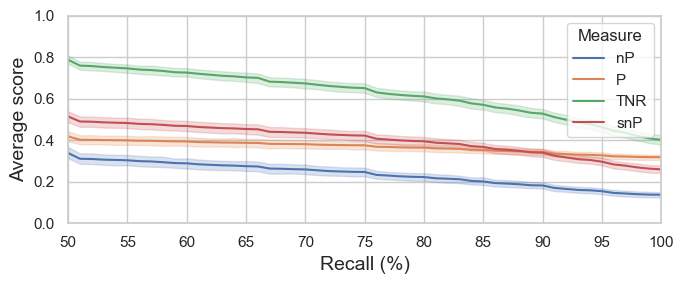

In [43]:
plt.figure(figsize=(7, 3))

sns.set_theme(style="whitegrid")

sns.lineplot(levels_means_df, x="Recall", y="Score", hue="Measure")

plt.xticks(
    np.arange(levels_means_df["Recall"].min(), levels_means_df["Recall"].max() + 1, 5.0)
)

# min and max y axis from 0 to 1
plt.ylim(0, 1)
plt.xlim(levels_means_df["Recall"].min(), levels_means_df["Recall"].max())

plt.xlabel("Recall (%)", fontsize=14)
plt.ylabel("Average score", fontsize=14)

plt.tight_layout()
plt.savefig("../reports/impact_of_recall.pdf", dpi=300)